# dropkick

---

#### Automated cell filtering for scRNA-seq data.  
#### The following tutorial will walk through the `dropkick` pipeline, parameters, and outputs.

In [1]:
import scanpy as sc
import dropkick

/home/cody/.virtualenvs/dropkick/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


### 1. Read in counts data
`dropkick` works primarily with [**Scanpy**](https://icb-scanpy.readthedocs-hosted.com/en/stable/)'s `AnnData` objects, and accepts input files in `.h5ad` or flat (`.csv`, `.tsv`) format. It also writes outputs to `.h5ad` files when called from the command line.

We can read in an example mouse colon dataset generated using **inDrops** single-cell RNA sequencing ([Klein, *et al.*, 2015](https://www.sciencedirect.com/science/article/pii/S0092867415005000?via%3Dihub)).

In [2]:
a = sc.read("data/S1.h5ad")

---
### 1.5. Plot QC metrics (optional)
The `qc` module has functions for plotting total UMI distribution and ambient genes, to give an idea of overall data quality and amenability to `dropkick` filtering. 

In [3]:
# simple preprocessing of anndata object to get metrics for plot
a = dropkick.recipe_dropkick(a, filter=False, n_hvgs=None, X_final="raw_counts")

Calculating metrics:
Top 10 ambient genes have dropout rates between 0.136 and 3.559 percent:
	['mt-Co2', 'mt-Co1', 'mt-Cytb', 'mt-Atp6', 'mt-Nd1', 'mt-Nd4', 'Gm42418', 'mt-Co3', 'mt-Nd2', 'mt-Nd3']


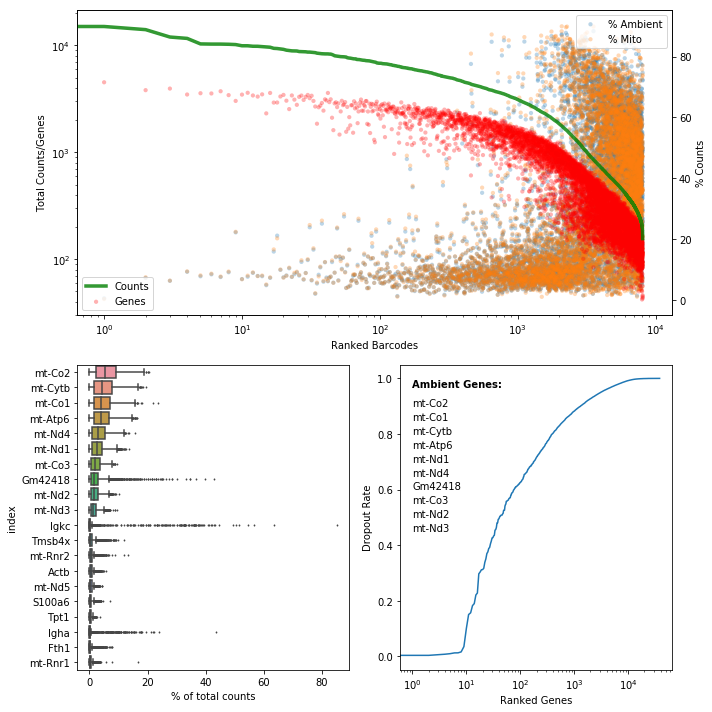

In [5]:
from dropkick.qc import summary_plot
summary_plot(a)

---
### 2. Run `dropkick` pipeline function
This tool preprocesses the data to automatically calculate thresholds on global metrics, then trains a [glmnet](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html)-style logistic regression model to determine scores and labels for each barcode in the dataset describing likelihood of being a real cell (rather than empty droplet). 

In [7]:
%time a_rc = dropkick.dropkick(a)

Ignoring 5 cells with less than 50 genes detected
Ignoring 10527 genes with zero total counts
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts', 'pct_counts_ambient']
Training LogitNet with alphas: [0.1]
Chosen lambda value: [0.05474023]
Assigning scores and labels
Done!

CPU times: user 6min 37s, sys: 6min 20s, total: 12min 57s
Wall time: 3min 37s


---
### 3. Explore output
Running **dropkick** interactively adds the following attributes to the input `AnnData` object:
* `.obs['dropkick_score']`
    * Probability of being a real cell
    * Values closer to 0 indicate empty droplets with high ambient RNA content
* `.obs['dropkick_label']`
    * Binary label generated by using cutoff of 0.5 on `'dropkick_score'`
    * Dropkick's best estimate of a "good" dataset
    * User is encouraged to adjust the cutoff according to whether they are more concerned with *false negatives* or *false positives*
* `.obs[<metrics>]`
    * Metrics used for thresholding (`metrics` parameter, default `['arcsinh_n_genes_by_counts','pct_counts_ambient']`, are kept
* `.var['dropkick_coef']`
    * Logistic regression coefficient values for each highly variable gene (HVG) determined by the **dropkick** pipeline
* `.uns['dropkick_thresholds']`
    * Dictionary of global metrics thresholded by **dropkick** (keys) with the resulting threshold values (values)
* `.uns['dropkick_args']`
    * Dictionary of all arguments used to run the pipeline

In [8]:
a

AnnData object with n_obs × n_vars = 8064 × 38459 
    obs: 'manual_label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'arcsinh_n_genes_by_counts', 'dropkick_score', 'dropkick_label'
    var: 'mito', 'dropout_rate', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'dropkick_coef'
    uns: 'dropkick_thresholds', 'dropkick_args'
    layers: 'raw_counts', 'norm_counts', 'arcsinh_norm'

We can use the `plot_thresh_obs` function to visualize the automated thresholds that determined **dropkick**'s training set...

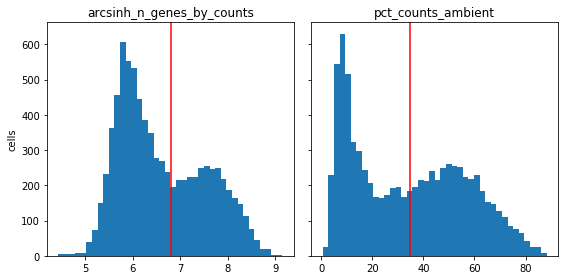

In [9]:
dropkick.plot_thresh_obs(a, a.uns['dropkick_thresholds'])

Look at the distribution of **dropkick** scores for each barcode...

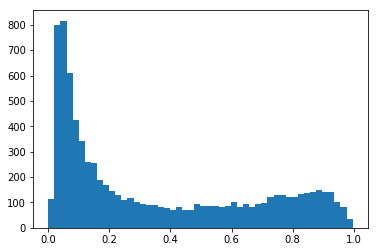

In [10]:
import matplotlib.pyplot as plt
_ = plt.hist(a.obs['dropkick_score'], bins=50)

And view the top gene coefficients for both good cells (highly positive) and putative empty droplets (highly negative).

In [11]:
dropkick.coef_inventory(a)


Top HVGs by coefficient value (good cells):
index
Cd74       0.315479
Mpeg1      0.206138
Mzb1       0.188323
Cd79a      0.159817
Tmem123    0.151778
Slpi       0.145391
Nedd4      0.134955
Snx3       0.131944
Suclg1     0.131467
Cstb       0.124350
Name: dropkick_coef, dtype: float64

Bottom HVGs by coefficient value (bad droplets):
index
Zg16      -0.211364
Igha      -0.107757
Apoe      -0.059178
Hormad2   -0.031605
Gm37504   -0.025622
Mmp12     -0.019879
Vimp      -0.018883
Strn3     -0.018402
Sox2      -0.017745
Krtap14   -0.017603
Name: dropkick_coef, dtype: float64

1550 coefficients equal to zero. Model sparsity: 77.5 %



The `coef_plot` function will plot the **coefficient values** and **cross validation (CV) scores** for the tested values of **lambda**.

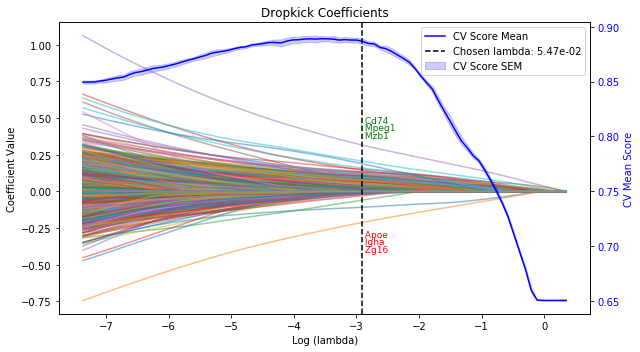

In [12]:
dropkick.coef_plot(a)

---
#### Now, let's take the **dropkick** labels and visualize our resulting, filtered dataset.

In [17]:
a_filtered = a[a.obs.dropkick_label==1,:].copy()  # make a copy of our AnnData object

For simplicity, **dropkick** has a "recipe" function that will perform normalization for us.

In [18]:
# here, we want to end up working with normalized, arcsinh-transformed counts where genes are scaled to unit variance and zero-centered
# we also set filter=True to remove any genes and cells with zero total counts
# we perform a variable gene selection for 2000 HVGs before further processing
a_filtered = dropkick.recipe_dropkick(a_filtered, X_final="arcsinh_norm", filter=True, n_hvgs=2000, verbose=True)
a_filtered.shape

Ignoring 11841 genes with zero total counts
Calculating metrics:
Top 10 ambient genes have dropout rates between 0.113 and 2.145 percent:
	['mt-Co2', 'mt-Co1', 'mt-Atp6', 'mt-Cytb', 'mt-Nd1', 'mt-Nd4', 'mt-Co3', 'Gm42418', 'mt-Nd2', 'Tpt1']
Determining 2000 highly variable genes


(2657, 26618)

Next we can run **PCA** as an initial dimension reduction, followed by **UMAP** to embed the cells in a 2-dimensional space.

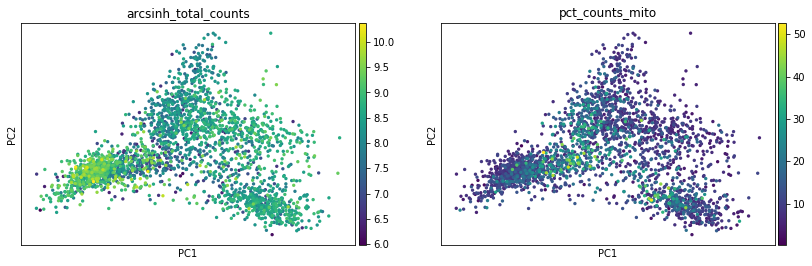

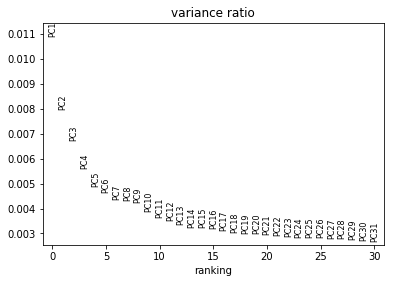

In [19]:
sc.tl.pca(a_filtered, n_comps=50, use_highly_variable=True)
sc.pl.pca(a_filtered, color=["arcsinh_total_counts","pct_counts_mito"])
sc.pl.pca_variance_ratio(a_filtered)

Using the first few PCs, construct a neighbor graph that can be clustered with the **Louvain** algorithm, then embed the dataset using **UMAP** and visualize resulting clusters.

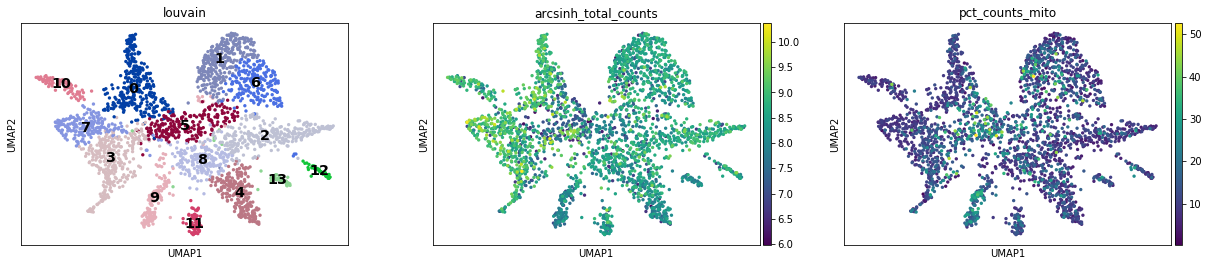

In [22]:
sc.pp.neighbors(a_filtered, n_neighbors=30, random_state=1, n_pcs=15)
sc.tl.louvain(a_filtered)
sc.tl.umap(a_filtered, random_state=1)
# plot results
sc.pl.umap(a_filtered, color=["louvain","arcsinh_total_counts","pct_counts_mito"], legend_loc="on data", legend_fontsize="x-large")

Looks like **dropkick** did a good job removing cells with low `total_counts` and high `pct_counts_mito`.

Now do some differential expression testing to try to identify all the cell types in our dataset, using built-in **Scanpy** functions.

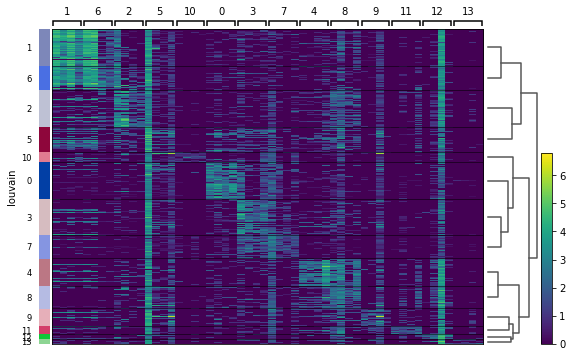

In [23]:
a_filtered.X = a_filtered.layers["log1p_norm"].copy()  # need to return log1p data to working layer for DE testing
sc.tl.rank_genes_groups(a_filtered, groupby="louvain")
sc.pl.rank_genes_groups_heatmap(a_filtered, groupby="louvain", n_genes=4)